# Jeg prøver en konkurrence på kaggle, hvor jeg skal bruge unsupervised k-means clustering.

https://www.kaggle.com/competitions/k-means-clustering-for-heart-disease-analysis/overview

In [1]:
import pandas as pd
import numpy as np
from numpy.random import uniform
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from matplotlib.colors import ListedColormap
from time import sleep
from IPython import display

In [2]:
sns.set_style('white')

cmap = ListedColormap(sns.xkcd_palette(['denim blue', 
                                        'medium green', 
                                        'pale red']))



In [3]:
cmap = ListedColormap(sns.color_palette('Paired', 10))

# split data op i trænings og test data

muligvis overhovedet ikke nødvendigt at gøre dette i forhold til konkurrencen. 

at splitte dataen op i test og træningsdata, for at se om den også kan forudsige data den ikke er blevet trænet på. det kaldes krydsvalidering.

For mig er det bedst practice at gøre det, men for konkurrencens resultat er det muligvis værre at gøre sådan her, da jeg mister 20% af min data, og der er ikke ret meget i forvejen.

##### Har lige fundet ud af at med unsupervised learning, deler man ikke data op i træning og test data. Man bruger hele datasættet. Målet med unsupervised learning er ofte at opnå indsigt i data eller at reducere dimensioner for visualisering eller yderligere analyse. Dette gøres ved at udnytte de naturlige strukturer eller mønstre i dataene.

In [4]:
data = pd.read_csv('data/heart_disease_cleaned.csv')
submission = pd.read_csv('data/sample.csv')

#X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

# Normaliser data.

Man skal normalisere træningsdata og testdata seperat. Hvis man skalere inden split, vil det lede til data lækage og data bias.

------------------------------------------------------------------------------------------------------------------------------------------------------------
Correct! When it comes to scaling data for machine learning, it’s generally recommended to avoid scaling the test data directly. Instead, follow these steps:

Split the Data: First, split your dataset into training and test subsets. The training set will be used for model training, while the test set remains untouched until evaluation.

Scale the Training Data: Apply the scaling transformation (such as standardization or normalization) only to the training data. This ensures that the model learns from standardized features during training.

Keep Test Data Untouched: The test data should remain in its original form (unscaled) throughout the process. This prevents any information leakage from the test set into the training process.

Evaluate Model Performance: After training your model using the scaled training data, evaluate its performance on the unscaled test data. This provides a realistic assessment of how well the model generalizes to new, unseen examples.

## label encoding for categorical variables:

metoden LabelEncode laver alle string værdier om til kategorier af tal, for at gøre det nemmere at arbejde med for cluster modellen.

In [5]:
def LabelEncode(data):
    data['sex'] = data['sex'].astype('category').cat.codes
    data['dataset'] = data['dataset'].astype('category').cat.codes
    data['cp'] = data['cp'].astype('category').cat.codes
    data['fbs'] = data['fbs'].astype('category').cat.codes
    data['restecg'] = data['restecg'].astype('category').cat.codes
    data['exang'] = data['exang'].astype('category').cat.codes
    data['slope'] = data['slope'].astype('category').cat.codes
    data['thal'] = data['thal'].astype('category').cat.codes
    return data

In [6]:
data = LabelEncode(data)

data.head()

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
0,63,1,0,3,145.0,233.0,2,1,150.0,0,2.3,1,0.0,1
1,67,1,0,0,160.0,286.0,0,1,108.0,2,1.5,2,3.0,2
2,37,1,0,2,130.0,250.0,0,2,187.0,0,3.5,1,0.0,2
3,41,0,0,1,130.0,204.0,0,1,172.0,0,1.4,3,0.0,2
4,57,0,0,0,120.0,354.0,0,2,163.0,2,0.6,3,0.0,2


## Numerisk skalering med standardscaler

In [7]:
scaler = StandardScaler()

numerical_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']

data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

data.head()

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
0,0.997239,1,0,3,0.655168,0.265296,2,1,0.415440,0,1.388283,1,0.0,1
1,1.410080,1,0,0,1.385273,0.788985,0,1,-1.331904,2,0.611680,2,3.0,2
2,-1.686228,1,0,2,-0.074936,0.433272,0,2,1.954767,0,2.553189,1,0.0,2
3,-1.273387,0,0,1,-0.074936,-0.021251,0,1,1.330715,0,0.514604,3,0.0,2
4,0.377978,0,0,0,-0.561673,1.460888,0,2,0.956285,2,-0.261999,3,0.0,2


PCA er en måde at reducere mængden af features i datasættet, og beholde så meget varians som muligt.
Det gør det nemmere at visualisere og fjerne noget støj.

Combining PCA and K-means can lead to improved segmentation results:
- PCA reduces the dimensionality of the data, making it easier for K-means to identify meaningful clusters.
- By reducing noise, PCA enhances the performance of K-means.
- The two techniques complement each other, resulting in more accurate and interpretable clusters1.

In [8]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data)

pca_data

array([[ 9.40347005e-01,  1.85582248e-01],
       [ 1.00209476e+00, -2.83930826e+00],
       [ 1.94055440e+00,  1.23735378e+00],
       [ 2.62048789e+00,  6.55823893e-01],
       [ 2.15174506e+00, -7.10095490e-01],
       [ 2.22711062e+00, -1.04624683e+00],
       [ 8.41603569e-01,  1.54840565e-01],
       [ 2.06839861e+00,  8.93194370e-03],
       [ 2.99683361e+00,  9.59793953e-01],
       [ 2.00703165e+00,  1.07460656e+00],
       [ 2.23705126e+00,  6.89388998e-01],
       [ 2.65900845e+00,  1.43456697e-01],
       [ 2.18557289e+00, -1.93735982e+00],
       [ 1.67626120e+00, -1.56672129e+00],
       [ 1.80700704e+00, -1.90643382e+00],
       [ 2.93167407e+00,  2.90496816e-01],
       [ 2.25563836e+00, -9.02684356e-01],
       [ 2.65199337e+00, -1.61707513e-01],
       [ 2.71796418e+00, -3.91492752e-01],
       [ 2.32501879e+00,  1.34980261e+00],
       [ 2.17751433e+00, -2.00937875e+00],
       [ 2.74959833e+00,  5.99123781e-01],
       [ 1.62827783e+00,  1.08974274e+00],
       [ 1.

## Træn og evaluer modellen

n_init: hvor mange gange modellen kører.
n_clusters: hvor mange clusters jeg vil have bliver lavet.

In [9]:
n_cluster = 3
model = KMeans(n_clusters=n_cluster, random_state=42, n_init=10)

model.fit(pca_data)

print(silhouette_score(pca_data, model.labels_))

c:\Users\Christian\anaconda3\envs\ml-env\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


0.4921130544230227


## Se cluster labels

In [10]:
cluster_labels = model.labels_

print(cluster_labels)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 1 0 0 0 0
 0 0 0 0 0 1 0 2 0 0 0 0 2 0 0 0 0 1 0 2 0 0 0 0 0 0 0 1 2 1 0 1 0 0 1 1 0
 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 2 0 1 0 0 1 1 1 1 1 1 1 1 2 0 0 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1
 1 0 1]


## Simpelt cluster plot

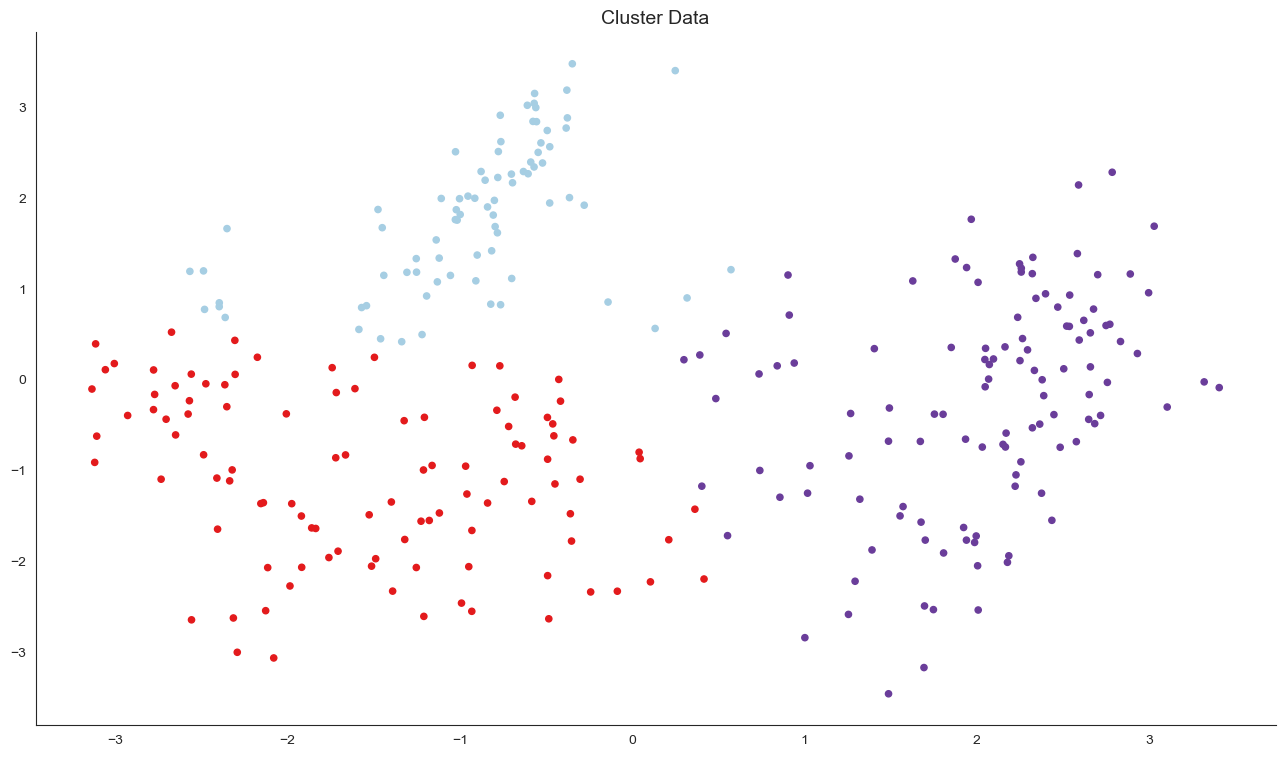

In [11]:

x, y = pca_data.T
plt.figure(figsize=(16, 9))
plt.scatter(x, y, c=cluster_labels, s=20, cmap=cmap)
plt.title('Cluster Data', fontsize=14)
sns.despine();

# Voronoi Plot

Jeg har fået inspiration til mine plots fra min bog Machine learning for algorithmic trading :D selv om jeg har droppet at læse bogen fra A-B, giver den mig sygt meget inspiration. Der står alt muligt lækkert i, og jeg tror det er det bogen er lavet til. ikke fra A-B, men et machine learning leksikon.

Voronoi plot giver en visuel fremvisning af hvordan modellen optimere sig selv.

In [12]:
x_min, x_max = x.min() - 1, x.max() + 1
y_min, y_max = y.min() - 1, y.max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, .01), 
                     np.arange(y_min, y_max, .01))

In [13]:
def distance_to_center(centroids, data, assignments, cdist):
    distance = 0
    for c, centroid in enumerate(centroids):
        assigned_points = data[assignments == c, :]
        distance += np.sum(cdist(assigned_points, centroid.reshape(-1, 2)))
    return distance

def optimize_centroids(data, assignments):
    data_combined = np.column_stack((assignments.reshape(-1, 1), data))
    centroids = pd.DataFrame(data=data_combined).groupby(0).mean()
    return centroids.values

def assign_points(centroids, data, cdist):
    dist = cdist(data, centroids)        # all pairwise distances
    assignments = np.argmin(dist, axis=1)   # centroid with min distance
    return assignments

In [14]:
def plot_voronoi(x, y, labels, centroids, assignments,
                 distance, iteration, step, ax, delay=1):
    ax.clear()
    ax.scatter(x, y, c=labels, s=20, cmap=cmap)

    # plot cluster centers
    ax.scatter(*centroids.T,
               marker='o',
               c='w',
               s=200,
               edgecolor='k',
               zorder=9)

    for i, c in enumerate(centroids):
        ax.scatter(c[0], c[1],
                   marker=f'${i}$',
                   s=50,
                   edgecolor='k',
                   zorder=10)

    # plot links to centroid
    cx, cy = centroids.T
    for i, label in enumerate(assignments):
        ax.plot([x[i], cx[label]], 
                [y[i], cy[label]], 
                ls='--',
                color='k', 
                lw=0.5)

    Z = assign_points(centroids, 
                      np.c_[xx.ravel(),  
                            yy.ravel()],
                            cdist).reshape(xx.shape)
    
    plt.imshow(Z, interpolation='nearest', 
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=cmap, 
               aspect='auto', 
               origin='lower', 
               alpha=.2)
    title = f'Iteration: {iteration} | {step} | Distance: {distance:,.1f}'
    ax.set_title(title)
    sns.despine()
    display.display(plt.gcf())
    display.clear_output(wait=True)
    sleep(delay)

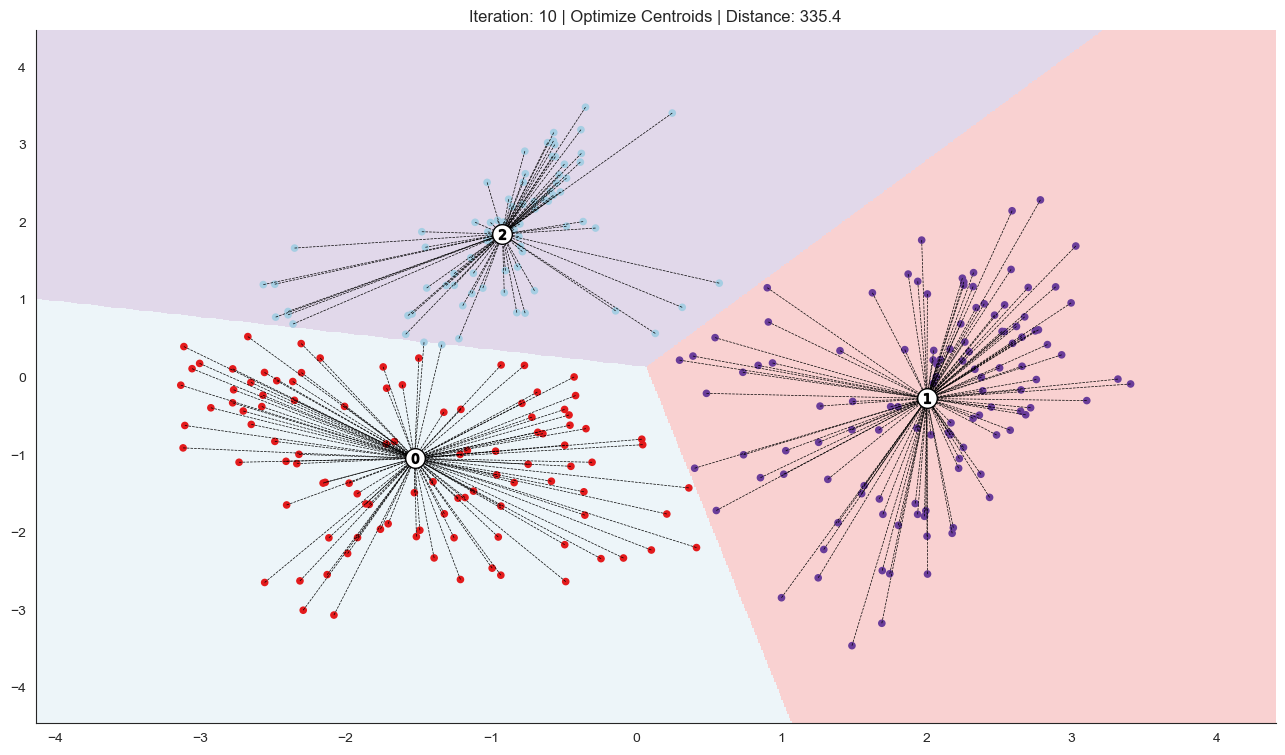

In [15]:
x_init = uniform(x.min(), x.max(),
                 size=n_cluster)
y_init = uniform(y.min(), y.max(),
                 size=n_cluster)
centroids = np.column_stack((x_init, y_init))

distance = np.sum(np.min(cdist(pca_data,
                               centroids),
                         axis=1))

fig, ax = plt.subplots(figsize=(16, 9))

iteration, tolerance, delta = 0, 1e-4, np.inf

while delta > tolerance:
    assignments = assign_points(centroids, pca_data, cdist)
    plot_voronoi(x, y, cluster_labels,
                 centroids,
                 assignments,
                 distance,
                 iteration,
                 step='Assign Data',
                 ax=ax)

    centroids = optimize_centroids(pca_data, assignments)
    delta = distance - distance_to_center(centroids,
                                          pca_data,
                                          assignments,
                                          cdist)
    distance -= delta

    plot_voronoi(x, y, cluster_labels,
                 centroids,
                 assignments,
                 distance,
                 iteration,
                 step='Optimize Centroids',
                 ax=ax)
    iteration += 1

# Evaluer Mængden af cluster med inertia

The k-Means objective function suggests we compare the evolution of the inertia or within-cluster variance. Initially, additional centroids decrease the inertia sharply because new clusters improve the overall fit. Once an appropriate number of clusters has been found (assuming it exists), new centroids reduce the within-cluster variance by much less as they tend to split natural groupings. 

Hence, when k-Means finds a good cluster representation of the data, the inertia tends to follow an elbow-shaped path similar to the explained variance ratio for PCA.


inertia er en error metric for kmeans clustering. 

Inertia (Cluster Sum of Squares):
- Inertia quantifies how well data points within a cluster are grouped together.
- It’s calculated by summing up the squared distances of each data point from the center of its assigned cluster.
- Smaller inertia values indicate more cohesive clusters, where data points are tightly grouped around their centroids.
- The goal is to minimize inertia by finding the optimal number of clusters.

K-Means Clustering:
- K-means is an unsupervised learning algorithm that partitions data into (k) clusters.
- It iteratively assigns data points to the nearest cluster centroid and recalculates centroids.
- The process continues until convergence (when centroids no longer change significantly).
- The final result is a set of clusters with minimized inertia.

Trade-Offs:
- While lower inertia is desirable, be cautious not to overfit the data by choosing too many clusters.
- Sometimes, a slightly higher inertia with fewer clusters may lead to better interpretability and generalization.

lavere værdi er bedre.

In [16]:
def inertia_plot_update(inertias, ax, delay=1):
    inertias.plot(color='k',
                  lw=1,
                  title='Inertia',
                  ax=ax,
                  xlim=(inertias.index[0], inertias.index[-1]),
                  ylim=(0, inertias.max()))
    ax.set_xlabel(f"Clusters")
    ax.set_ylabel("Inertia Value")
    ax.axes.get_xaxis().set_visible(True)
    ax.axes.get_yaxis().set_visible(True)    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    sleep(delay)

In [17]:
def plot_kmeans_result(data, labels, centroids,
                       assignments, ncluster, Z, ax):

    # plot data
    ax.scatter(x, y, c=labels, s=20, cmap=cmap)

    # plot cluster centers
    ax.scatter(*centroids.T,
               marker='o',
               c='w',
               s=200,
               edgecolor='k',
               zorder=9)

    for i, c in enumerate(centroids):
        ax.scatter(*c,
                   marker=f'${i}$',
                   s=50,
                   edgecolor=['k'],
                   zorder=10)
        xy = pd.DataFrame(data[assignments == i],
                          columns=['x', 'y']).assign(cx=c[0],
                                                     cy=c[1])

        ax.plot(xy[['x', 'cx']].T.values,
                xy[['y', 'cy']].T.values,
                ls='--',
                color='k',
                lw=0.5)

    # plot voronoi
    ax.imshow(Z, interpolation='nearest',
              extent=(xx.min(), xx.max(), yy.min(), yy.max()),
              cmap=cmap,
              aspect='auto',
              origin='lower',
              alpha=.2)
    ax.set_title(f'Number of Clusters: {ncluster}')
    plt.tight_layout()

## Elbow Experiment


In [18]:
max_clusters = 7
cluster_list = list(range(1, max_clusters + 1))
inertias = pd.Series(index=cluster_list)

#### plot det

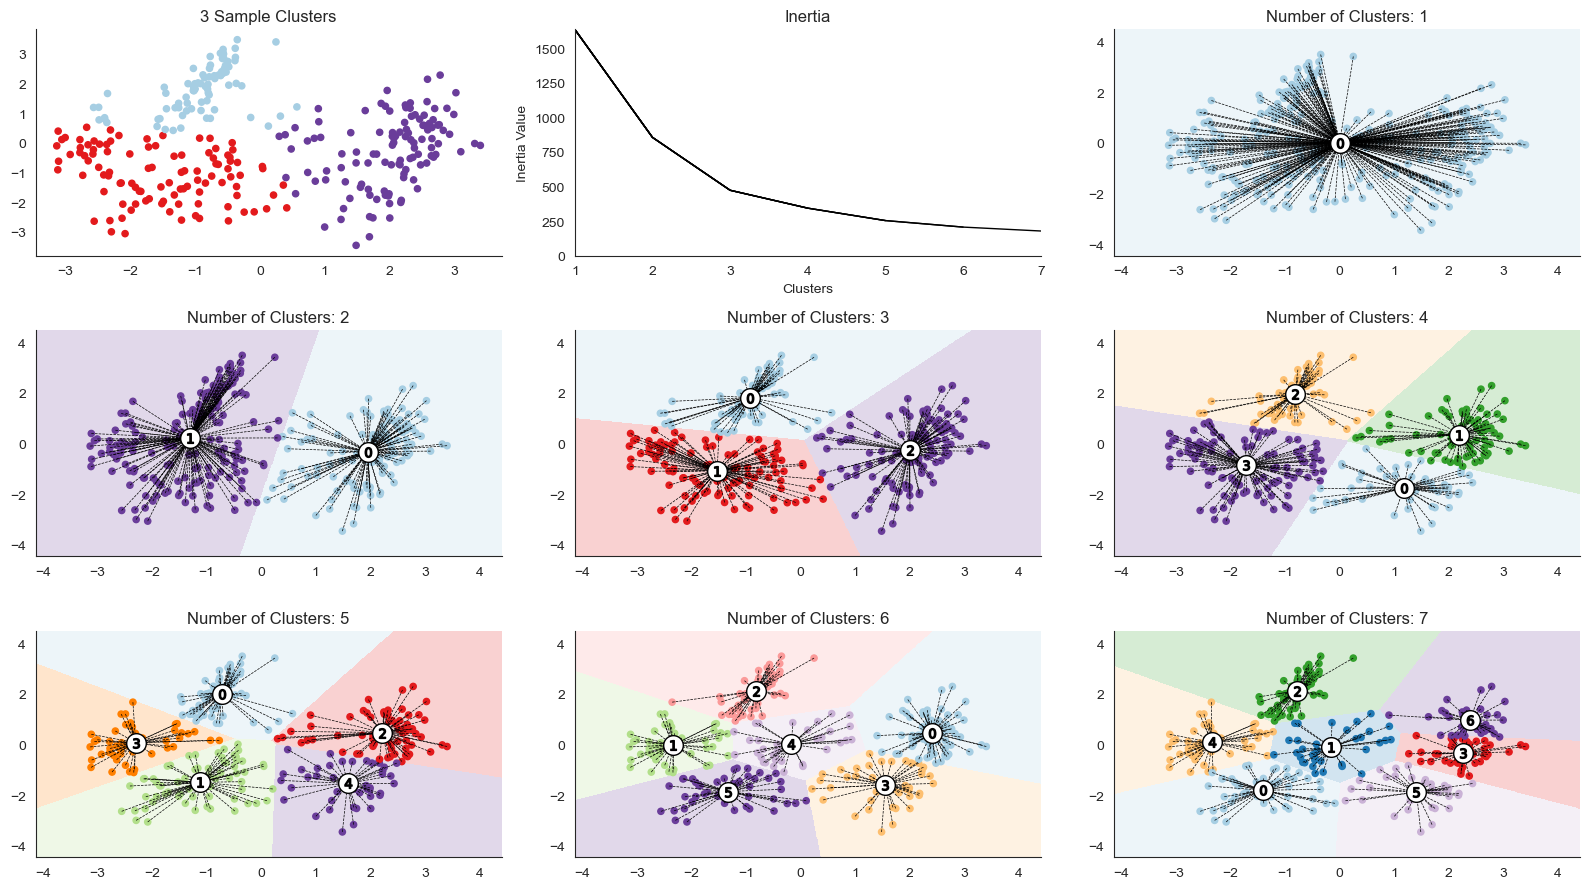

In [19]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(16, 9))
axes = np.array(axes).flatten()

axes[0].scatter(x, y, 
                c=cluster_labels, s=20, 
                cmap=cmap)
axes[0].set_title('{} Sample Clusters'.format(n_cluster))
for ax in axes:
    ax.axes.get_xaxis().set_visible(True)
    ax.axes.get_yaxis().set_visible(True)
sns.despine();

for c, n_cluster in enumerate(range(1, max_clusters + 1), 2):
    kmeans = KMeans(n_clusters=n_cluster, random_state=42, n_init=10).fit(pca_data)
    centroids, assignments, inertia = kmeans.cluster_centers_, kmeans.labels_, kmeans.inertia_
    inertias[n_cluster] = inertia
    inertia_plot_update(inertias, axes[1])
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plot_kmeans_result(pca_data, kmeans.labels_, centroids, assignments,  n_cluster, Z, axes[c])
fig.tight_layout()

# Evaluating the Silhuette Score

The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) provides a more detailed picture of cluster quality. It answers the question: how far are the points in the nearest cluster relative to the points in the assigned cluster?
To this end, it compares the mean intra-cluster distance (a) to the mean distance of the nearest-cluster (b) and computes the following score s:

$$s=\frac{b−a}{\max(a,b)}\quad\in{[−1, 1]}$$

The score can vary between -1 and 1, but negative values are unlikely in practice because they imply that the majority of points are assigned to the wrong cluster. A useful visualization of the silhouette score compares the values for each data point to the global average because it highlights the coherence of each cluster relative to the global configuration. The rule of thumb is to avoid clusters with mean scores below the average for all samples.

The following figure shows an excerpt from the silhouette plot for three and four clusters, where the former highlights the poor fit of cluster 1 by sub-par contributions to the global silhouette score, whereas all of the four clusters have some values that exhibit above-average scores.

In [20]:
def plot_silhouette(values, y_lower, i, n_cluster, ax):
    cluster_size = values.shape[0]
    y_upper = y_lower + cluster_size

    color = plt.cm.viridis(i / n_cluster)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, values,
                facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * cluster_size, str(i))
    y_lower = y_upper + 10
    return y_lower

In [21]:
def format_silhouette_plot(ax):
    ax.set_title("Silhouette Plot")
    ax.set_xlabel(f"Silhouette Coefficient: {silhouette_avg}")
    ax.set_ylabel("Cluster Label")
    ax.axvline(x=silhouette_avg, 
               color='red', 
               linestyle='--', 
               lw=1)
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [22]:
def plot_final_assignments(x, y, centroids, 
                           assignments, n_cluster, ax):
    c = plt.cm.viridis(assignments / n_cluster)
    ax.scatter(x, y, marker='.', s=30, 
               lw=0, alpha=0.7, c=c, edgecolor='k')
    ax.scatter(*centroids.T, marker='o',  
               c='w', s=200, edgecolor='k')
    for i, c in enumerate(centroids):
        ax.scatter(*c, marker='${}$'.format(i), 
                   s=50, edgecolor='k')

    ax.set_title('{} Clusters'.format(n_cluster))

In [23]:
cluster_list = list(range(1, max_clusters + 1))
inertias = pd.Series(index=cluster_list)

0.43688777051103544


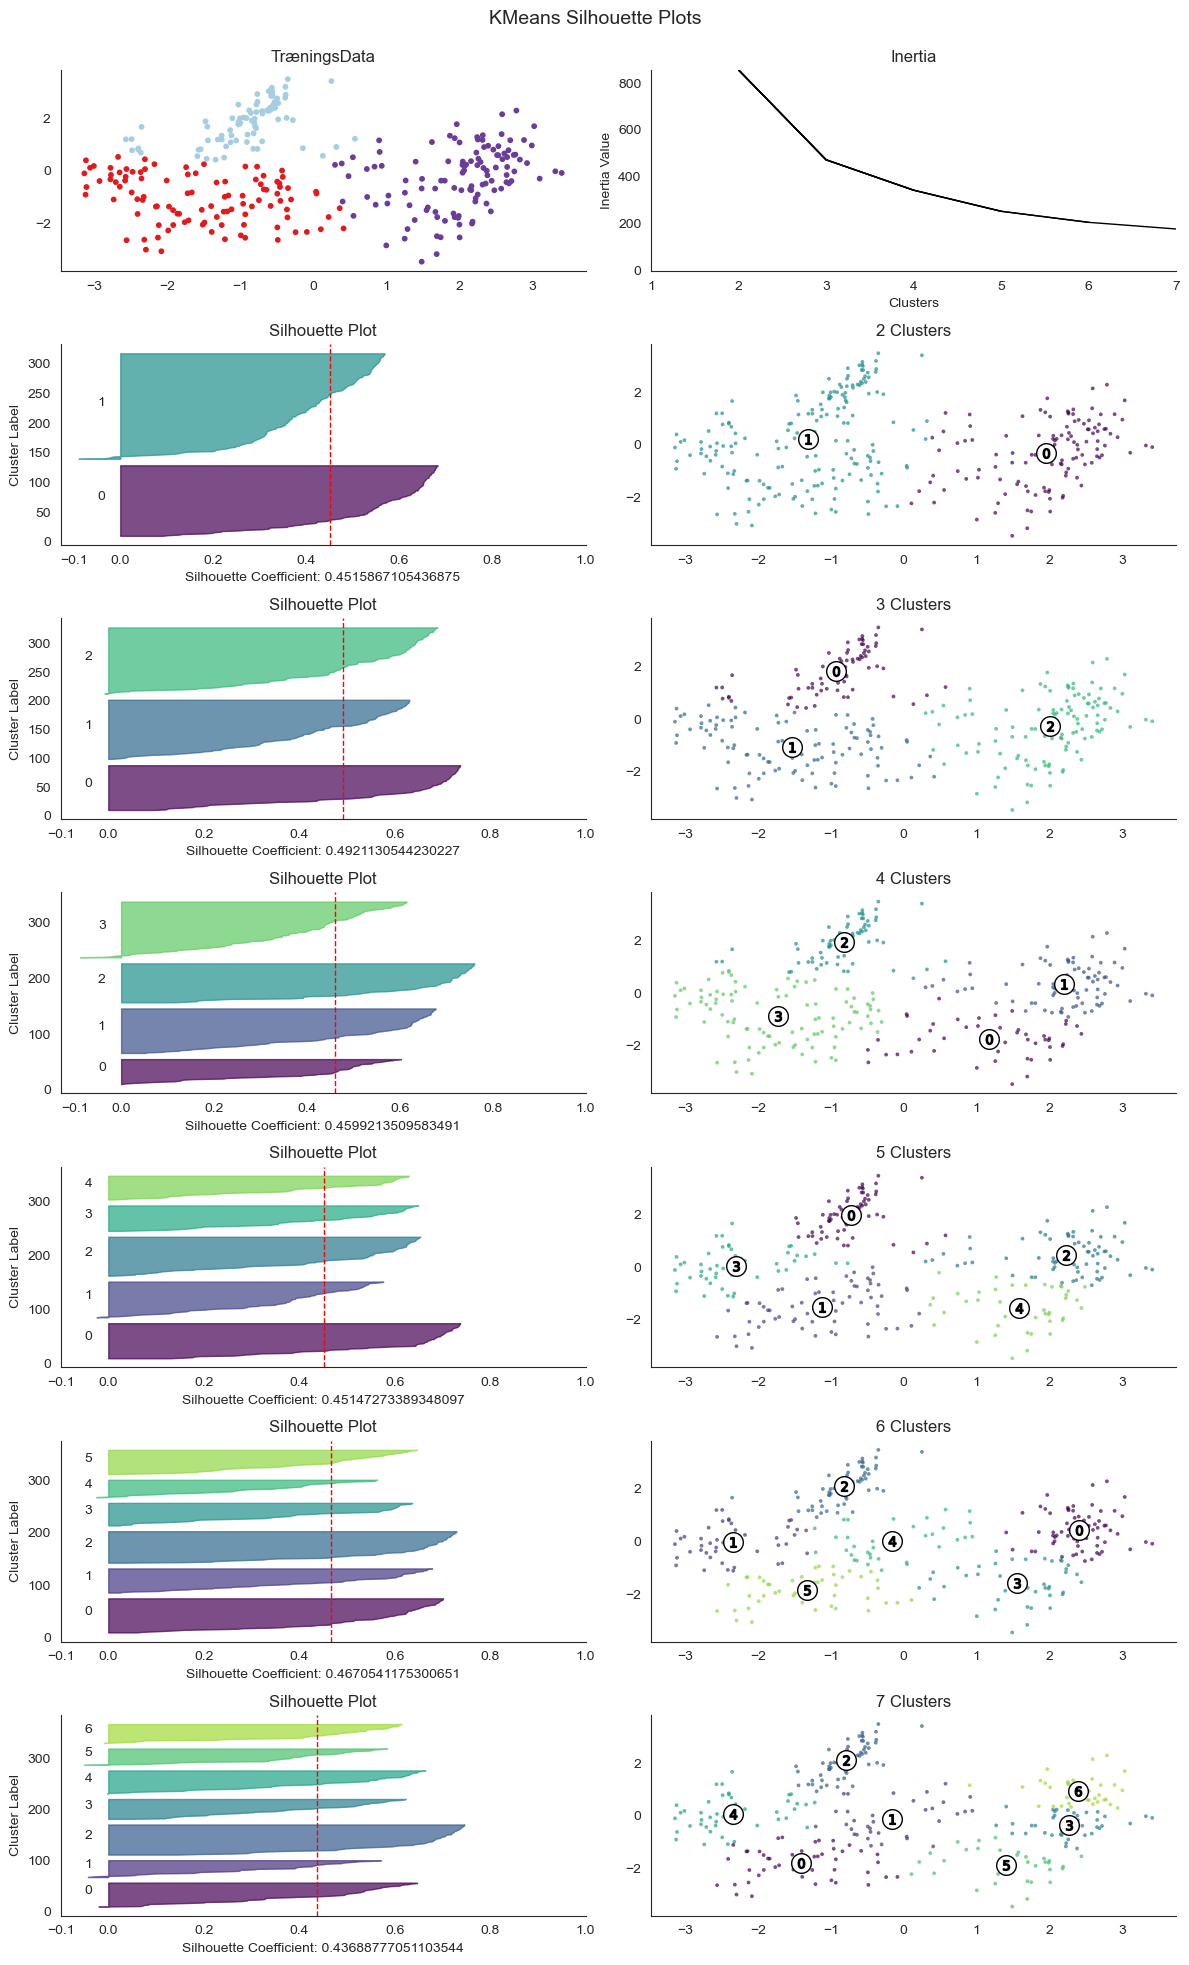

In [24]:
fig, axes = plt.subplots(ncols=2,
                         nrows=max_clusters,
                         figsize=(12, 20))

axes[0][0].scatter(x, y, c=cluster_labels, s=10, cmap=cmap)
axes[0][0].set_title('TræningsData')

for i in range(max_clusters):
    for j in [0, 1]:
        axes[i][j].axes.get_xaxis().set_visible(True)
        axes[i][j].axes.get_yaxis().set_visible(True)
sns.despine()

for row, n_cluster in enumerate(range(2, max_clusters + 1), 1):
    kmeans = KMeans(n_clusters=n_cluster,
                    random_state=42, n_init=10).fit(pca_data)

    centroids, assignments, inertia = (kmeans.cluster_centers_,
                                       kmeans.labels_,
                                       kmeans.inertia_)
    inertias[n_cluster] = inertia
    inertia_plot_update(inertias, axes[0][1])

    silhouette_avg = silhouette_score(pca_data, assignments)
    silhouette_values = silhouette_samples(pca_data, assignments)
    silhouette_plot, cluster_plot = axes[row]

    y_lower = 10
    for i in range(n_cluster):
        y_lower = plot_silhouette(np.sort(silhouette_values[assignments == i]),
                                  y_lower,
                                  i,
                                  n_cluster,
                                  silhouette_plot)
    format_silhouette_plot(silhouette_plot)
    plot_final_assignments(x, y, centroids, assignments,
                           n_cluster, cluster_plot)
    fig.tight_layout()
    print(silhouette_avg)


fig.suptitle(f'KMeans Silhouette Plots',
             fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.95)

In [25]:

submission['cluster'] = cluster_labels
submission.to_csv('data/submission.csv', index=False)

submission

,id,cluster
0,0,2
1,1,2
2,3,2
3,4,2
4,7,2
...,...,...
294,910,1
295,911,1
296,912,1
297,916,0
